<a href="https://colab.research.google.com/github/Anushkajoshi000/FruitsObjectDetection/blob/main/fruitOB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%%bash

git clone --depth 1 https://github.com/tensorflow/models

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
!pip search opencv-python-headless

!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless




ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.
Found existing installation: opencv-python-headless 4.8.0.76
Uninstalling opencv-python-headless-4.8.0.76:
  Successfully uninstalled opencv-python-headless-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.4 MB/s eta 0:00:00


In [ ]:
!pip install kaggle --upgrade -q

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving fruitsOD.zip to fruitsOD.zip


In [ ]:
import zipfile
import os

zip_file_path = "/content/fruitsOD.zip"
extraction_path = "extraction_directory"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extraction_path)


In [ ]:
# Move the extracted contents
os.system(f"mv {extraction_path}/train_zip/* {extraction_path}/test_zip/* fruit-images/")

256

In [ ]:
# Download the dataset
#!kaggle datasets download mbkinaci/fruit-images-for-object-detection


# Extract the downloaded zip file
#!unzip fruit-images-for-object-detection.zip


In [ ]:
%%bash

mkdir -p ~/.kaggle
echo '{"username":"KAGGLE_USERNAME","key":"KAGGLE_KEY"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
%%bash

kaggle datasets download mbkinaci/fruit-images-for-object-detection
unzip fruit-images-for-object-detection

mkdir -p fruit-images
mv train_zip/* fruit-images/
mv test_zip/* fruit-images/

CalledProcessError: ignored

In [ ]:
import glob
import io
import os
from collections import namedtuple
from xml.etree import ElementTree as tree
import pandas as pd
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
def encode_class(row_label):
  class_mapping = {'apple': 1, 'orange': 2, 'banana': 3}
  return class_mapping.get(row_label, None)

In [ ]:
def split(df, group):
    Data = namedtuple('data', ['filename', 'object'])
    groups = df.groupby(group)
    return [Data(filename, groups.get_group(x)) for filename, x in zip(groups.groups.keys(), groups.groups)]

In [ ]:
def create_tf_example(group, path):
    groups_path = os.path.join(path, f'{group.filename}')
    with tf.gfile.GFile(groups_path, 'rb') as f:
        encoded_jpg = f.read()

    image = Image.open(io.BytesIO(encoded_jpg))
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # 5. Now, store the dimensions of the bounding boxes, along with the classes of each object contained in the image:
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(encode_class(row['class']))
    # 6. Create a tf.train.Features object that will contain relevant information about the image and its objects:
    features = tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    })
    # 7. Return a tf.train.Example structure initialized with the features created previously:
    return tf.train.Example(features=features)

In [ ]:
def bboxes_to_csv(path):
    xml_list = []
    bboxes_pattern = os.path.sep.join([path, '*.xml'])
    for xml_file in glob.glob(bboxes_pattern):
        t = tree.parse(xml_file)
        root = t.getroot()

        for member in root.findall('object'):
            value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text))
            xml_list.append(value)

    column_names = ['filename', 'width', 'height', 'class','xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(xml_list, columns=column_names)
    return df

In [ ]:
base = 'fruit-images'
for subset in ['test', 'train']:
    labels_path = os.path.sep.join([base,f'{subset}_labels.csv'])
    bboxes_df = bboxes_to_csv(f'{base}/{subset}')
    bboxes_df.to_csv(labels_path, index=None)
    # 10. Then, use the same labels to produce the tf.train.Examples corresponding to the current subset of data being processed:
    writer = (tf.io.TFRecordWriter(f'{base}/{subset}.record'))
    examples = pd.read_csv(f'{base}/{subset}_labels.csv')
    grouped = split(examples, 'filename')
    path = os.path.join(f'{base}/{subset}')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()

In [ ]:
!ls -l fruit-images

total 8
-rw-r--r-- 1 root root 48 Aug 14 10:46 test_labels.csv
-rw-r--r-- 1 root root  0 Aug 14 10:46 test.record
-rw-r--r-- 1 root root 48 Aug 14 10:46 train_labels.csv
-rw-r--r-- 1 root root  0 Aug 14 10:46 train.record


In [ ]:
%%capture
%%bash

CHECKPOINT_DATE=20200711
MODEL_NAME=efficientdet_d0_coco17_tpu-32

curl -O http://download.tensorflow.org/models/object_detection/tf2/$CHECKPOINT_DATE/$MODEL_NAME.tar.gz
tar xzf $MODEL_NAME.tar.gz

In [ ]:
!ls efficientdet_d0_coco17_tpu-32/checkpoint

checkpoint  ckpt-0.data-00000-of-00001	ckpt-0.index


In [ ]:
%%writefile fruit-images/label_map.txt
item {
    id: 1
    name: 'apple'
}
item {
    id: 2
    name: 'orange'
}
item {
    id: 3
    name: 'banana'
}

Writing fruit-images/label_map.txt


In [ ]:
def get_pipeline_config(path):
    pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
    with tf.gfile.GFile(path, 'r') as f:
        text_format.Merge(f.read(), pipeline_config)

    return pipeline_config

def save_pipeline_config(pipeline_config, path):
    config_text = text_format.MessageToString(pipeline_config)
    with tf.gfile.Open(path, "wb") as f:
        tf.logging.info("Writing pipeline config file to %s", path)
        f.write(config_text)

In [ ]:
pipeline_config_path = 'models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
pipeline_config = get_pipeline_config(pipeline_config_path)

In [ ]:
pipeline_config.model.ssd.num_classes = 3

In [ ]:
pipeline_config.train_config.fine_tune_checkpoint = '/content/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0'

In [ ]:
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'

In [ ]:
pipeline_config.train_input_reader.label_map_path = '/content/fruit-images/label_map.txt'

In [ ]:
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = '/content/fruit-images/train.record'

In [ ]:
pipeline_config.eval_input_reader[0].label_map_path = '/content/fruit-images/label_map.txt'

In [ ]:
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = '/content/fruit-images/test.record'

In [ ]:
save_pipeline_config(pipeline_config, 'pipeline.config')

In [ ]:
!chmod +x train_script.sh


chmod: cannot access 'train_script.sh': No such file or directory


In [ ]:
%%writefile train_script.sh
#!/bin/bash

cd models/research/object_detection

mkdir -p /content/training

CONFIG_PATH=/content/pipeline.config
MODEL_DIR=/content/training

python model_main_tf2.py \
    --pipeline_config_path=$CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --num_train_steps=1000 \
    --batch_size=4 \
    --num_workers=2 \
    --enable_mixed_precision


Overwriting train_script.sh


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/training

<IPython.core.display.Javascript object>

In [ ]:
%%bash

cd models/research/object_detection

mkdir -p /content/inference_graph

CHECKPOINT_DIR=efficientdet_d0_coco17_tpu-32/checkpoint
CONFIG_PATH=/content/pipeline.config
OUTPUT_DIR=/content/inference_graph

python exporter_main_v2.py --trained_checkpoint_dir=$CHECKPOINT_DIR --pipeline_config_path=$CONFIG_PATH --output_directory=$OUTPUT_DIR

2023-08-14 10:55:36.230367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-14 10:55:39.579913: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0814 10:55:39.603121 135368995349120 ssd_efficientnet_bifpn_feature_extractor.py:150] EfficientDet EfficientNet backbone version: efficientnet-b0
I0814 10:55:39.603302 135368995349120 ssd_efficientnet_bifpn_feature_extractor.py:152] EfficientDet BiFPN num filters: 64
I0814 10:55:39.603377 135368995349120 ssd_efficientnet_bifpn_feature_extractor.py:153] EfficientDet BiFPN num iterations: 3
I0814 10:55:39.608608 135368995349120 efficientnet_model.py:143] round_filter input=32 output=32
I0814 10:55:39.645273 135368995349120 efficientnet_model.py:143] round_filter input=32 output=32
I0814 10:55:39.645396 135368995349120 efficientnet_model.py:143] round_fi

CalledProcessError: ignored

In [ ]:
#!/bin/bash

# Set the paths to your checkpoint directory, pipeline configuration file, and output directory
CHECKPOINT_DIR=/path/to/your/checkpoint_directory
CONFIG_PATH=/content/pipeline.config
OUTPUT_DIR=/content/inference_graph

# Change to the object detection directory
cd models/research/object_detection

# Create the output directory if it doesn't exist
mkdir -p $OUTPUT_DIR

# Run the exporter script
python exporter_main_v2.py --trained_checkpoint_dir=$CHECKPOINT_DIR --pipeline_config_path=$CONFIG_PATH --output_directory=$OUTPUT_DIR


SyntaxError: ignored

In [ ]:
import glob
import random
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz
from object_detection.utils.label_map_util import create_category_index_from_labelmap

%matplotlib inline

In [ ]:
def load_image(path):
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))
    width, height = image.size
    shape = (height, width, 3)
    image = np.array(image.getdata())
    image = image.reshape(shape).astype('uint8')
    return image

In [ ]:
def run_inference(net, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]
    # forward pass
    model = net.signatures['serving_default']
    result = model(input_tensor)
    # extract detections
    num_detections = int(result.pop('num_detections'))
    result = {key: value[0, :num_detections].numpy() for key, value in result.items()}
    result['num_detections'] = num_detections
    result['detection_classes'] = result['detection_classes'].astype('int64')
    # use mask if available
    if 'detection_masks' in result:
        detection_masks_reframed = ops.reframe_box_masks_to_image_masks(result['detection_masks'], result['detection_boxes'], image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return result

In [ ]:
labels_path = '/content/fruit-images/label_map.txt'
CATEGORY_IDX = create_category_index_from_labelmap(labels_path, use_display_name=True)
model_path = '/content/inference_graph/saved_model'
model = tf.saved_model.load(model_path)

NameError: ignored

In [ ]:
image_paths = list(glob.glob('fruit-images/test/*.jpg'))
image_paths = random.choices(image_paths, k=6)

In [ ]:
def get_image_with_boxes(model, path):
    image = load_image(path)
    annotation = run_inference(model, image)
    masks = annotation.get('detection_masks_reframed', None)
    viz.visualize_boxes_and_labels_on_image_array(
        image,
        annotation['detection_boxes'],
        annotation['detection_classes'],
        annotation['detection_scores'],
        CATEGORY_IDX,
        instance_masks=masks,
        use_normalized_coordinates=True,
        line_thickness=5)

    return image

In [ ]:
def load_image(path, target_shape=(600, 600, 3)):
    image = Image.open(path)
    image = image.resize(target_shape[:2], Image.ANTIALIAS)
    image = np.array(image)
    return image
image_paths = list(glob.glob('fruit-images/test/*.jpg'))
image_paths = random.choices(image_paths, k=6)
images = [load_image(path) for path in image_paths]


<ipython-input-62-105306864d85>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_shape[:2], Image.ANTIALIAS)


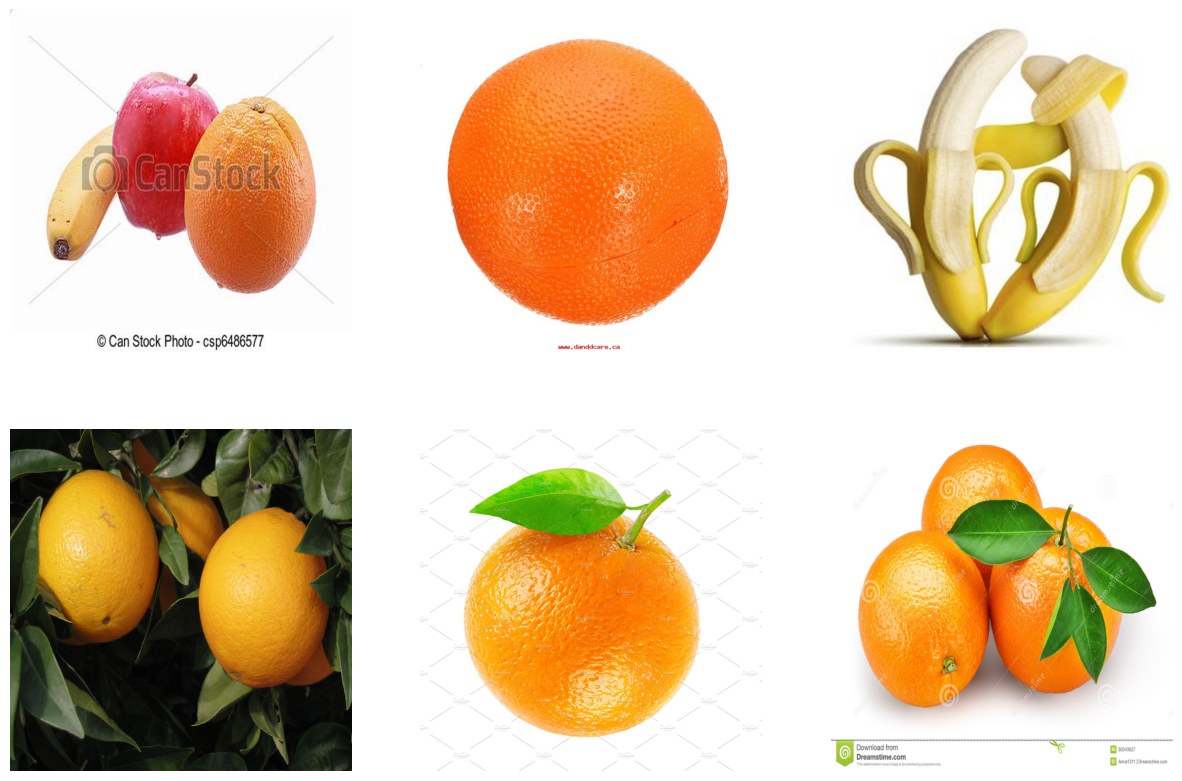

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15, 10))
for index, image in enumerate(images):
    row, col = int(index / 3), index % 3
    axis[row, col].imshow(image)
    axis[row, col].axis('off')

In [ ]:
from google.colab import files
import numpy as np
import io
from PIL import Image
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz

# Upload the image
uploaded = files.upload()

# Load and preprocess the uploaded image
def preprocess_image(image):
    image = Image.open(io.BytesIO(image))
    image = image.resize((600, 600), Image.ANTIALIAS)
    image = np.array(image)
    return image

# Choose the first uploaded image (you can modify this based on your need)
uploaded_image_path = next(iter(uploaded.keys()))
uploaded_image = uploaded[uploaded_image_path]
input_image = preprocess_image(uploaded_image)

# Run object detection
annotation = run_inference(model, input_image)

# Visualize the image with bounding boxes
plt.figure(figsize=(10, 8))
viz.visualize_boxes_and_labels_on_image_array(
    input_image,
    annotation['detection_boxes'],
    annotation['detection_classes'],
    annotation['detection_scores'],
    CATEGORY_IDX,
    instance_masks=annotation.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=5
)
plt.imshow(input_image)
plt.axis('off')
plt.show()
